# Importamos dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# importamos el mkt

mkt = pd.read_csv('mkt_bank.csv')

In [ ]:
mkt.head()

In [ ]:
mkt.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
mkt.head()

In [ ]:
# Hacemos algunas transformaciones

mkt.y.replace({'no': 0,
               'si': 1}, inplace=True)
mkt.drop_duplicates(inplace=True)

In [ ]:
mkt.y.value_counts()

# Preparamos la data

In [ ]:
X = mkt.drop('y', axis=1)
y = mkt['y']

In [ ]:
# importamos la libreria para poder realizar el One Hot Encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Como podemos ver, las columnas que tienen los valores categoricos son la segunda y la tercera (Geography y Gender)

cl = ColumnTransformer(transformers = [('OHE', OneHotEncoder(drop='first'), [1, 2, 3, 4, 5, 6, 7, 8, 9, 13]),
                                       ('scaler', StandardScaler(), [0, 10])], 
                       remainder='passthrough')
X = cl.fit_transform(X)

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

columns_num = [col for col in mkt.select_dtypes(include=numerics).columns if col != 'y']

In [ ]:
numeric_columns

In [ ]:
# Cambiamos la forma de obtener las columnas por una que nos permite acceder solo a las columnas de OHE

columns_ohe = cl.transformers_[0][1].get_feature_names().tolist()

columns_df = columns_ohe + columns_num

In [ ]:
X.shape

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
                                                X, y,
                                                test_size = 0.2,
                                                random_state = 15)

# Bagging

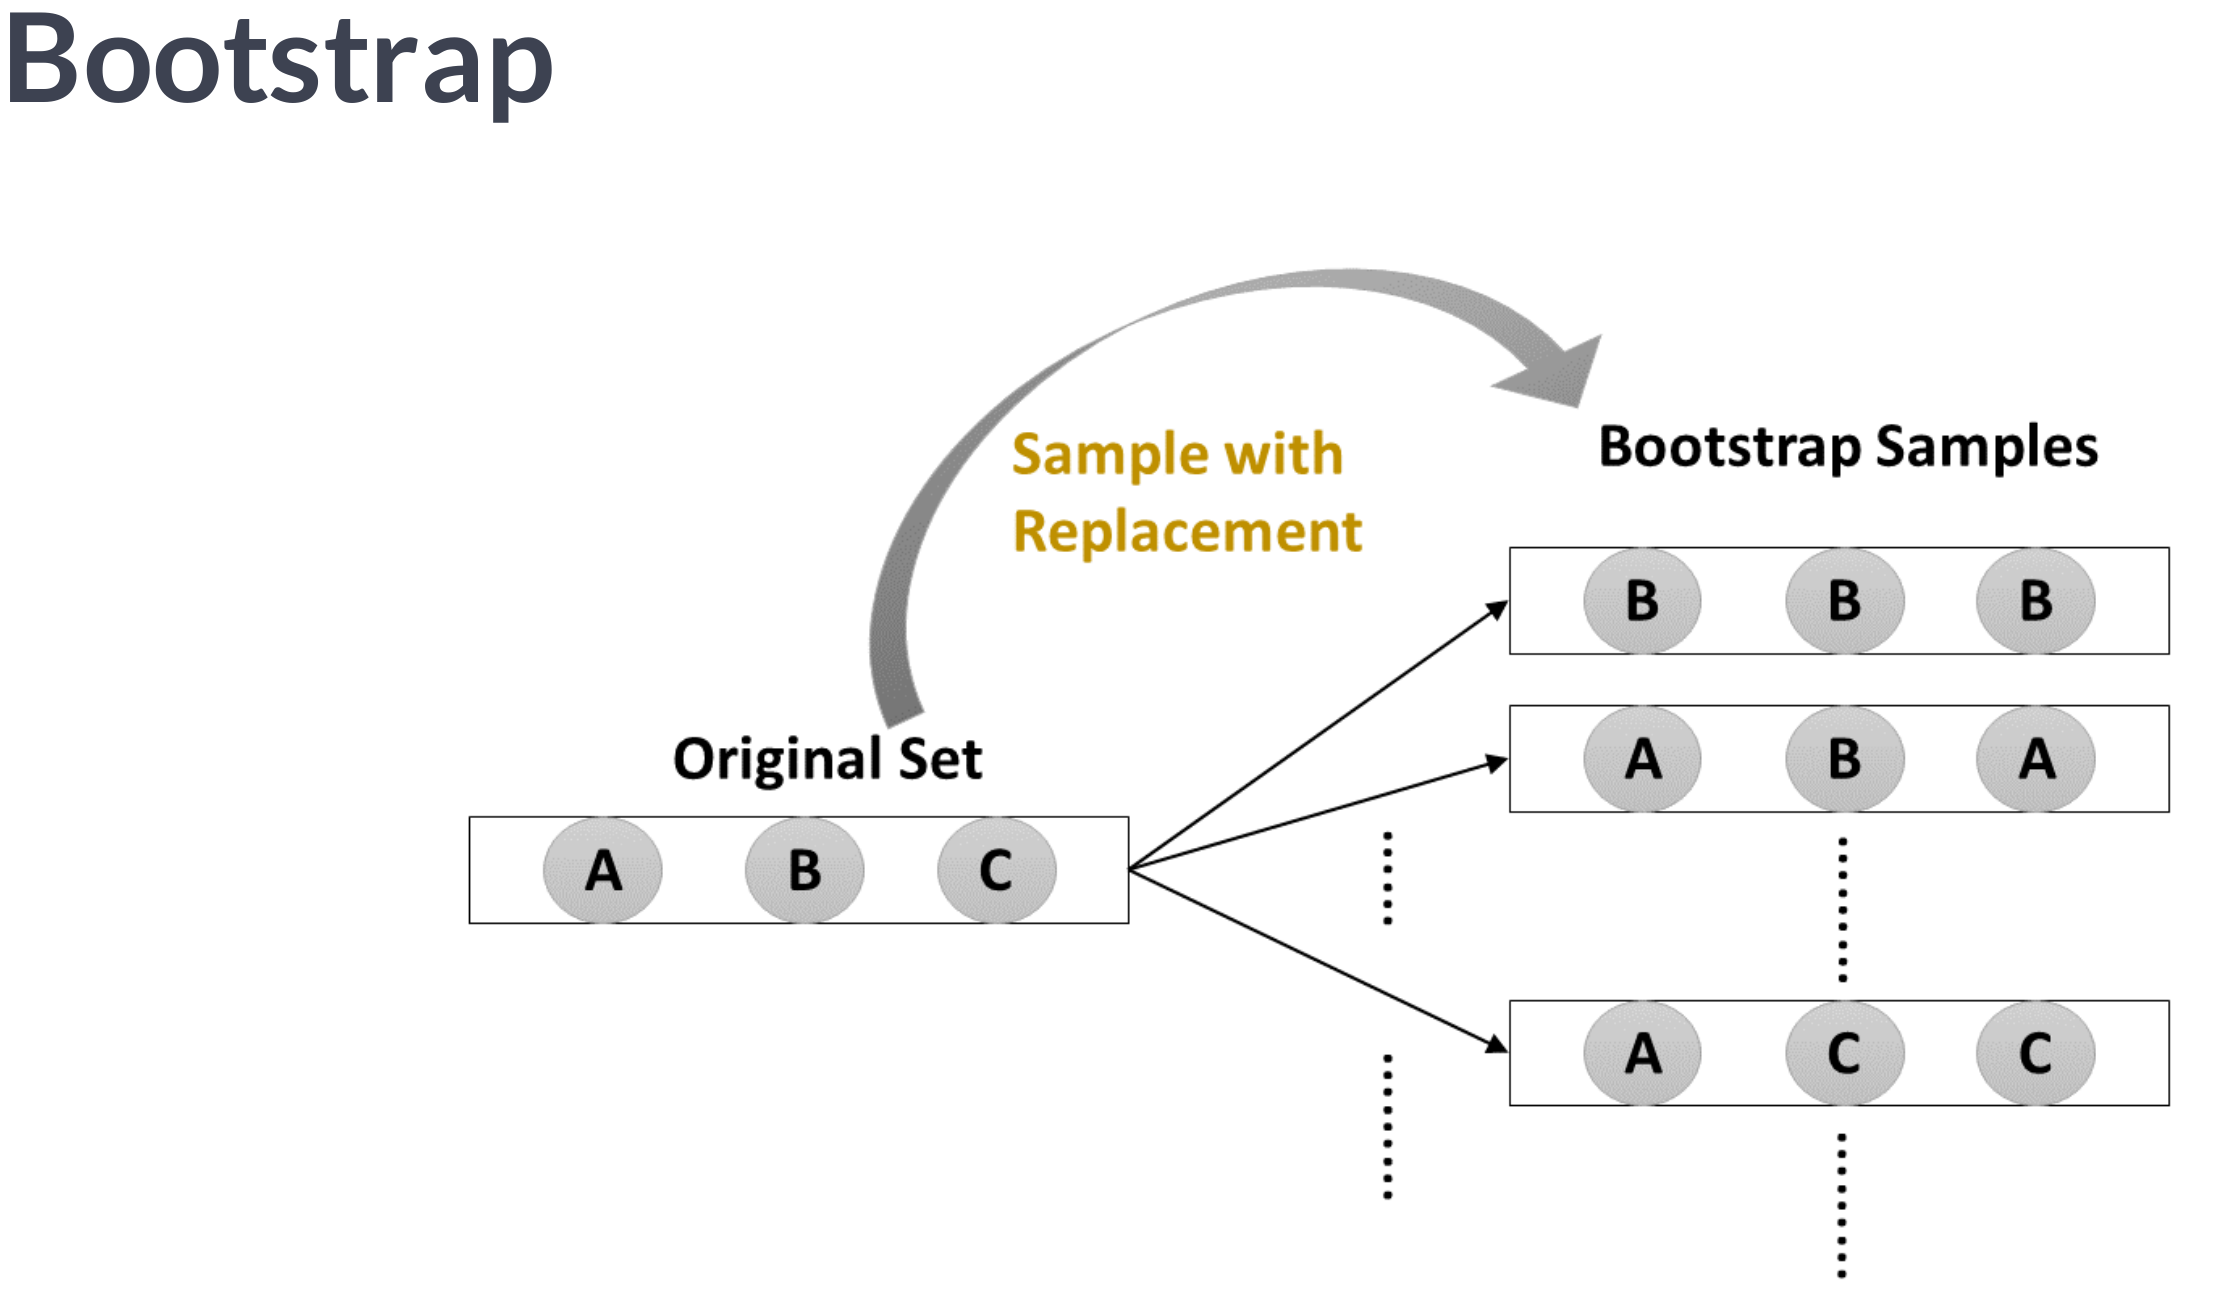

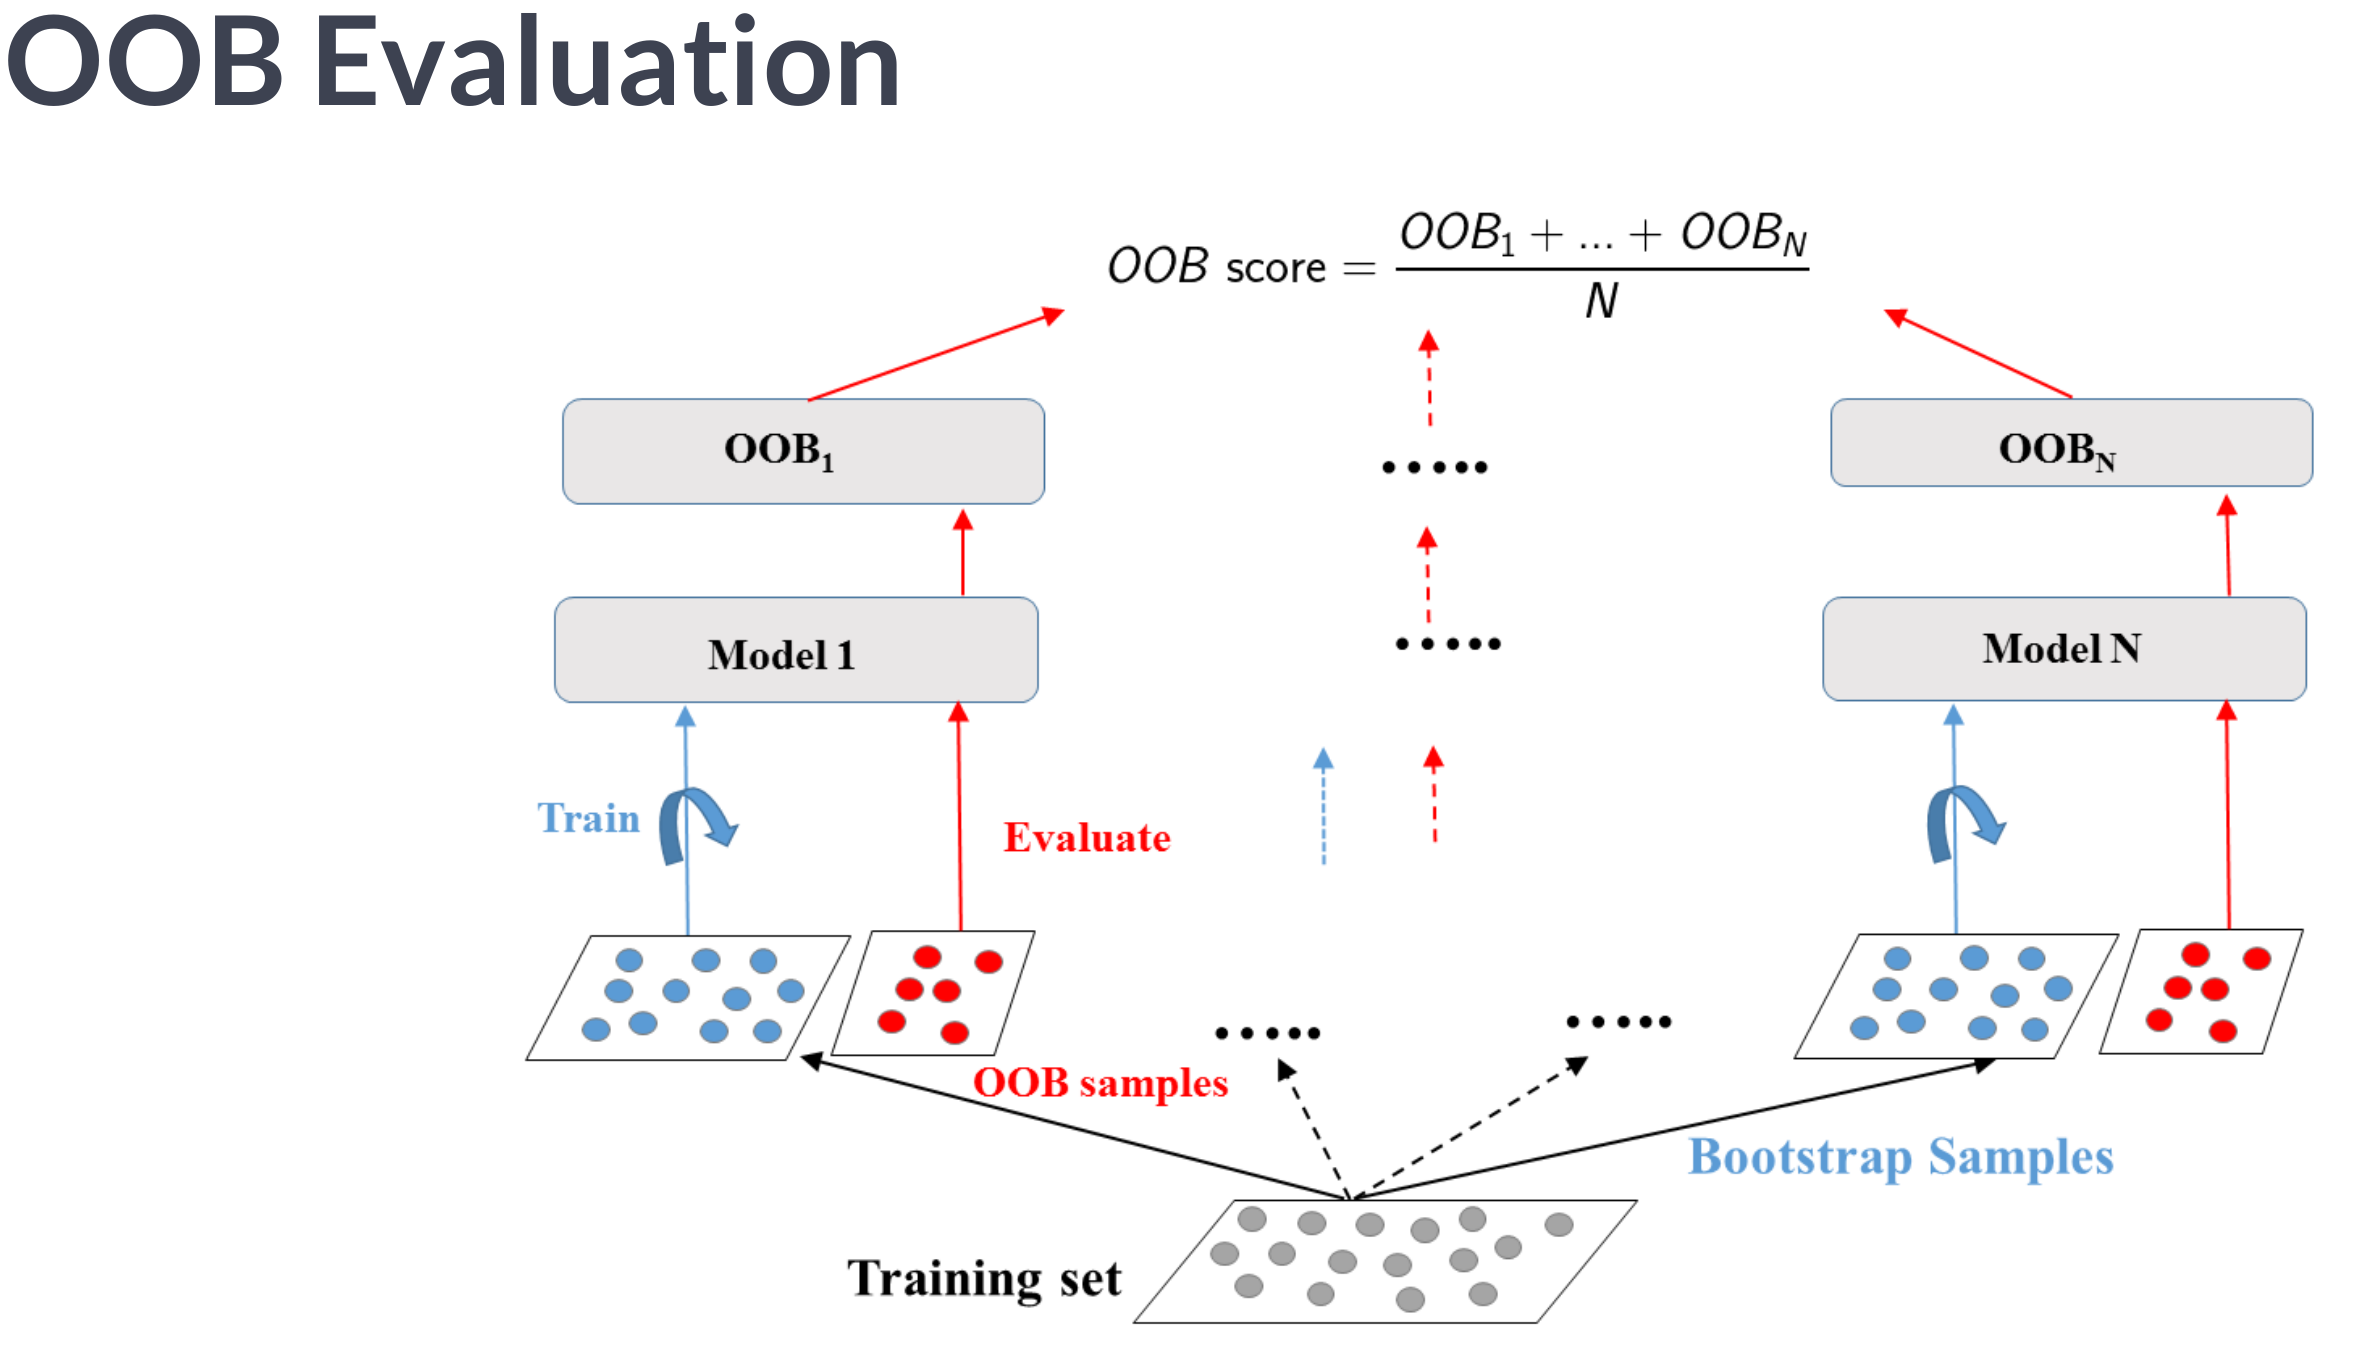

In [ ]:
# importamos las librerias necesarias para el modelo

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Inicializamos el modelo sobre el cual vamos a realizar el bagging, en este caso un arbol de decision
dt = DecisionTreeClassifier(max_depth=4)

# Inicializamos el Bagging classifier y elegimos la opcion de oob_score = True
# OOB es Out of Bag. En promedio para cada modelo 63% del training set es tomado
# el 67% restante consituye el Out Of Bag

bc = BaggingClassifier(base_estimator=dt, 
                       n_estimators=300,
                       oob_score=True,
                       n_jobs=-1)

# entrenamos al modelo con los datos de prueba

bc.fit(X_train, y_train)

# predecimos los datos que no conocemos
y_pred = bc.predict(X_val)

In [ ]:
# ahora vamos a performar dos evaluaciones, una con el validation set y otra con lo que quedo OOB

val_accuracy = accuracy_score(y_val, y_pred)

oob_accuracy = bc.oob_score_

print('El accuracy de validacion set es: {:.3f}'.format(val_accuracy))

In [ ]:
print('El acuracy de oob es: {:.3f}'.format(oob_accuracy))

# Random Forest


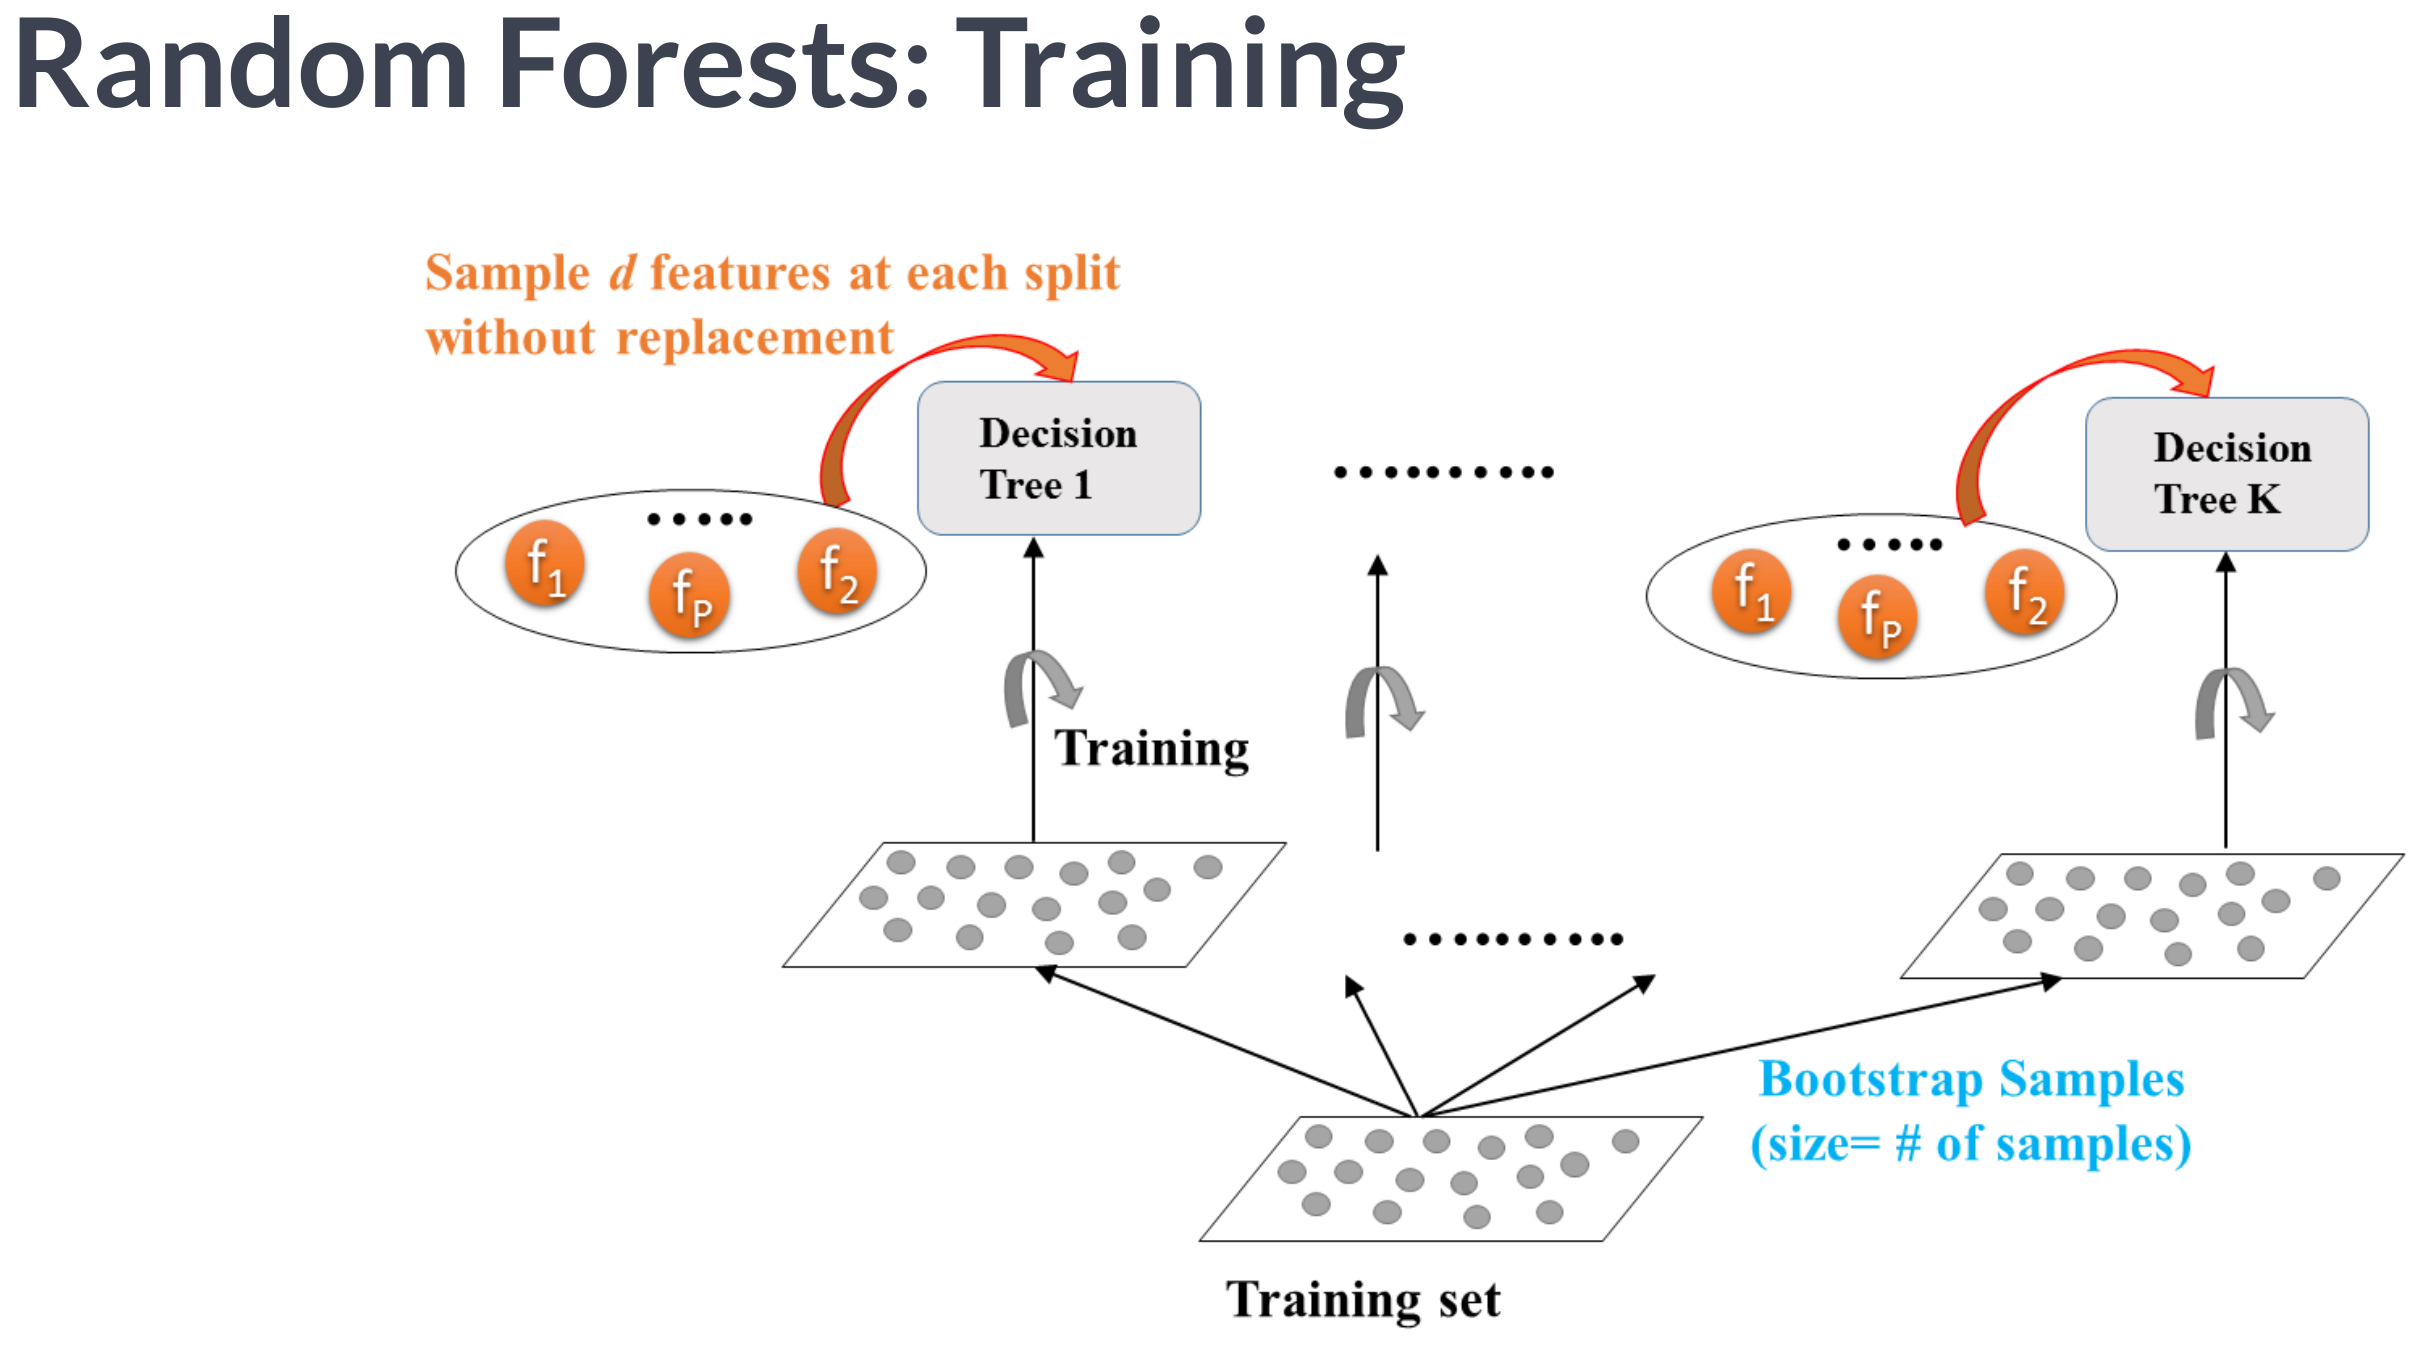

In [ ]:
# importamos las librerias necesarias para el modelo

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# definimos los parametros del modelo
# Los argumentos que modificaremos son la cantidad de predictores a utilizar para entrenar cada arbol, la cantidad
# de arboles, y la cantidad minima de datos en los nodos terminales


rf = RandomForestClassifier(n_estimators=400,
                            max_features= 6,
                            min_samples_leaf = 0.08,
                            random_state=123)

# entrenamos el modelo como siempre en sklearn
rf.fit(X_train, y_train)

## Importancia de las variables

In [ ]:
# Cuanto usen un atributo particular los arboles, nos dan una magnitud de que tan importante es dicha variable para reducir impureza
# para verificar la importancia de los atributos existe un metodo llamado feature_imporances_
# veamoslo en la practica

rf_imp = pd.Series(rf.feature_importances_, index=columns_df)

rf_imp.sort_values(ascending=False)

## Prediccion cambiando la cantidad de arboles

In [ ]:
# Vamos a probar con diferentes tamanos de arboles
# Para ello vamos a utilizar la funcion np.arange.

cant_arb = np.arange(20, 301, 20)
cant_arb

In [ ]:
# Creamos un diccionario para almacenar el accuracy en funcion a la cantidad de arboles

acc_arb = {'Cantidad_arb': [], 'acc_val': [], 'acc_train': []}

In [ ]:
for arbol in cant_arb:

  model = RandomForestClassifier(n_estimators=arbol,
                              max_features= 3,
                              max_depth = 7)
  

  model.fit(X_train, y_train)
  acc_arb['Cantidad_arb'].append(arbol)
  acc_arb['acc_val'].append(accuracy_score(y_val, model.predict(X_val)))
  acc_arb['acc_train'].append(accuracy_score(y_train, model.predict(X_train)))

In [ ]:
pd.DataFrame(acc_arb)

## Prediccion cambiando la cantidad de atributos

In [ ]:
# Vamos a probar con diferentes tamanos de atributos
# Para ello vamos a utilizar la funcion np.arange.

cant_atri = np.arange(1, 10)
cant_atri

In [ ]:
# Creamos un diccionario para almacenar el accuracy en funcion a la cantidad de arboles

acc_atri = {'Cantidad_atri': [], 'acc_val': [], 'acc_train': []}

In [ ]:
for atri in cant_atri:

  model = RandomForestClassifier(n_estimators=300,
                              max_features= atri,
                              max_depth = 7)
  

  model.fit(X_train, y_train)
  acc_atri['Cantidad_atri'].append(atri)
  acc_atri['acc_val'].append(accuracy_score(y_val, model.predict(X_val)))
  acc_atri['acc_train'].append(accuracy_score(y_train, model.predict(X_train)))

In [ ]:
pd.DataFrame(acc_atri)

Ahora vamos a tomar el mejor modelo que encontramos y volver a maximizar la funcion de beneficio.

In [ ]:
# el mejor modelo que encontramos es con 300 arboles y 5 atributos

rf_f = RandomForestClassifier(n_estimators=300,
                              max_features= 5,
                              max_depth = 7)

rf_f.fit(X_train, y_train)

In [ ]:
sns.set_style('whitegrid')

rf_imp = pd.Series(rf.feature_importances_, index=columns_df)
rf_imp.sort_values().plot(kind='barh')

## Umbral = 0.5

### Prediccion umbral

In [ ]:
# por defecto, el metodo predict realiza la clasificacion de la probabilidad con un umbral de 0.5

y_pred = rf_f.predict(X_val)

In [ ]:
# calculamos el accuracy del modelo

accuracy_score(y_val, y_pred)

In [ ]:
confusion_matrix(y_val, y_pred)

In [ ]:
# descomponemos la matriz de confusion en los cuatro posibles resultados

tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

In [ ]:
# Revisamos el calculo del accuracy con los datos que nos entrega la matriz

(tn + tp) / (tn + fp + fn + tp)

In [ ]:
p_tp = tp / (tn + fp + fn + tp)
p_fn = fn / (tn + fp + fn + tp)
p_tn = tn / (tn + fp + fn + tp)
p_fp = fp / (tn + fp + fn + tp)

In [ ]:
p_tp

In [ ]:
p_fn

In [ ]:
p_tn

In [ ]:
p_fp

### Matriz de beneficio 

In [ ]:
# vamos a definir los beneficios/costos asociados a cada alternativa

b_tp = 750
b_tn = 100
c_fp = -200
c_fn = -950

In [ ]:
valor_esperado = p_tp * b_tp + p_fn * c_fn + p_tn * b_tn + p_fp * c_fp
valor_esperado

## ROC CURVE

In [ ]:
from sklearn.metrics import roc_curve

y_pred_prob = rf_f.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

In [ ]:
thresholds

In [ ]:
fpr

In [ ]:
tpr

### AUC

In [ ]:
# una metrica importante es el area debajo del a curva roc y para calcularla utilizaremos la libreria
from sklearn.metrics import roc_auc_score

y_pred_prob = rf_f.predict_proba(X_val)[:,1]
print(f'El area debajo de la curva ROC es: {roc_auc_score(y_val, y_pred_prob):.3f}')

## Umbral = 0.2

### Prediccion umbral

In [ ]:
# vamos a tener que especializar la probabilidad en el valor que deseamos, en este caso 0.2

y_pred = rf_f.predict_proba(X_val)[:, 1] > 0.2

In [ ]:
# calculamos el accuracy del modelo

accuracy_score(y_val, y_pred)

In [ ]:
confusion_matrix(y_val, y_pred)

In [ ]:
# descomponemos la matriz de confusion en los cuatro posibles resultados

tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

In [ ]:
p_tp = tp / (tn + fp + fn + tp)
p_fn = fn / (tn + fp + fn + tp)
p_tn = tn / (tn + fp + fn + tp)
p_fp = fp / (tn + fp + fn + tp)

### Matriz de beneficio

In [ ]:
# como ya tenemos todas las demas matrices construidas, solo nos resta volver a realizar el calculo del valor esperado

valor_esperado = p_tp * b_tp + p_fn * c_fn + p_tn * b_tn + p_fp * c_fp
valor_esperado

# Actividades propuestas

1- Probar diferentes combinaciones de hiperparametros y encontrar la que mejor se ajusta a este problema.

2- Determinar cuales son las principales variables que estan influyendo en la decision del arbol.

3- Generar la prediccion tanto para el val como para el train set, buscando visualizar la relacion de los hiperparametros con el concepto de overfitting y underfitting.